In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import squidpy as sq
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import catboost
import json
import seaborn as sns


from tqdm import tqdm
import sys
sys.path.append('/Users/rssantanu/Desktop/codebase/constrained_FM')


import argparse



/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
scRNA = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE062025_MOSTA_g_10000_nzp_0.1.h5ad'))

/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
scRNA

AnnData object with n_obs × n_vars = 520815 × 10000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'celltype', 'Regulon - Arx', 'Regulon - Bclaf1', 'Regulon - Bmyc', 'Regulon - Brf1', 'Regulon - Cdx2', 'Regulon - Creb1', 'Regulon - Ctcf', 'Regulon - Cux1', 'Regulon - Dbx1', 'Regulon - Dlx5', 'Regulon - Dlx6', 'Regulon - E2f1', 'Regulon - E2f2', 'Regulon - E2f3', 'Regulon - E2f4', 'Regulon - E2f5', 'Regulon - E2f6', 'Regulon - E2f7', 'Regulon - E2f8', 'Regulon - Elf1', 'Regulon - Elf2', 'Regulon - Elk3', 'Regulon - Emx2', 'Regulon - Esrra', 'Regulon - Ets1', 'Regulon - Ets2', 'Regulon - Etv6', 'Regulon - Evx1', 'Regulon - Ezh2', 'Regulon - Fli1', 'Regulon - Foxa1', 'Regulon - Foxa2', 'Regulon - Foxa3', 'Regulon - Foxc2', 'Regulon - Foxf1', 'Regulon - Foxo1', 'Regulon - Foxp2', 'Regulon - Gabpa', 'Regulon - Gata1', 'Regulon - Gata4', 'Regulon - Gata5', 'Regulon - Gata6', 'Regulon - Gbx2', 'Regulon - Gsx1', 'Regulon - Gtf2f1', 'Regulon - Gtf

/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_17434/1218363691.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_17434/1218363691.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_17434/1218363691.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_17434/1218363691.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].asty

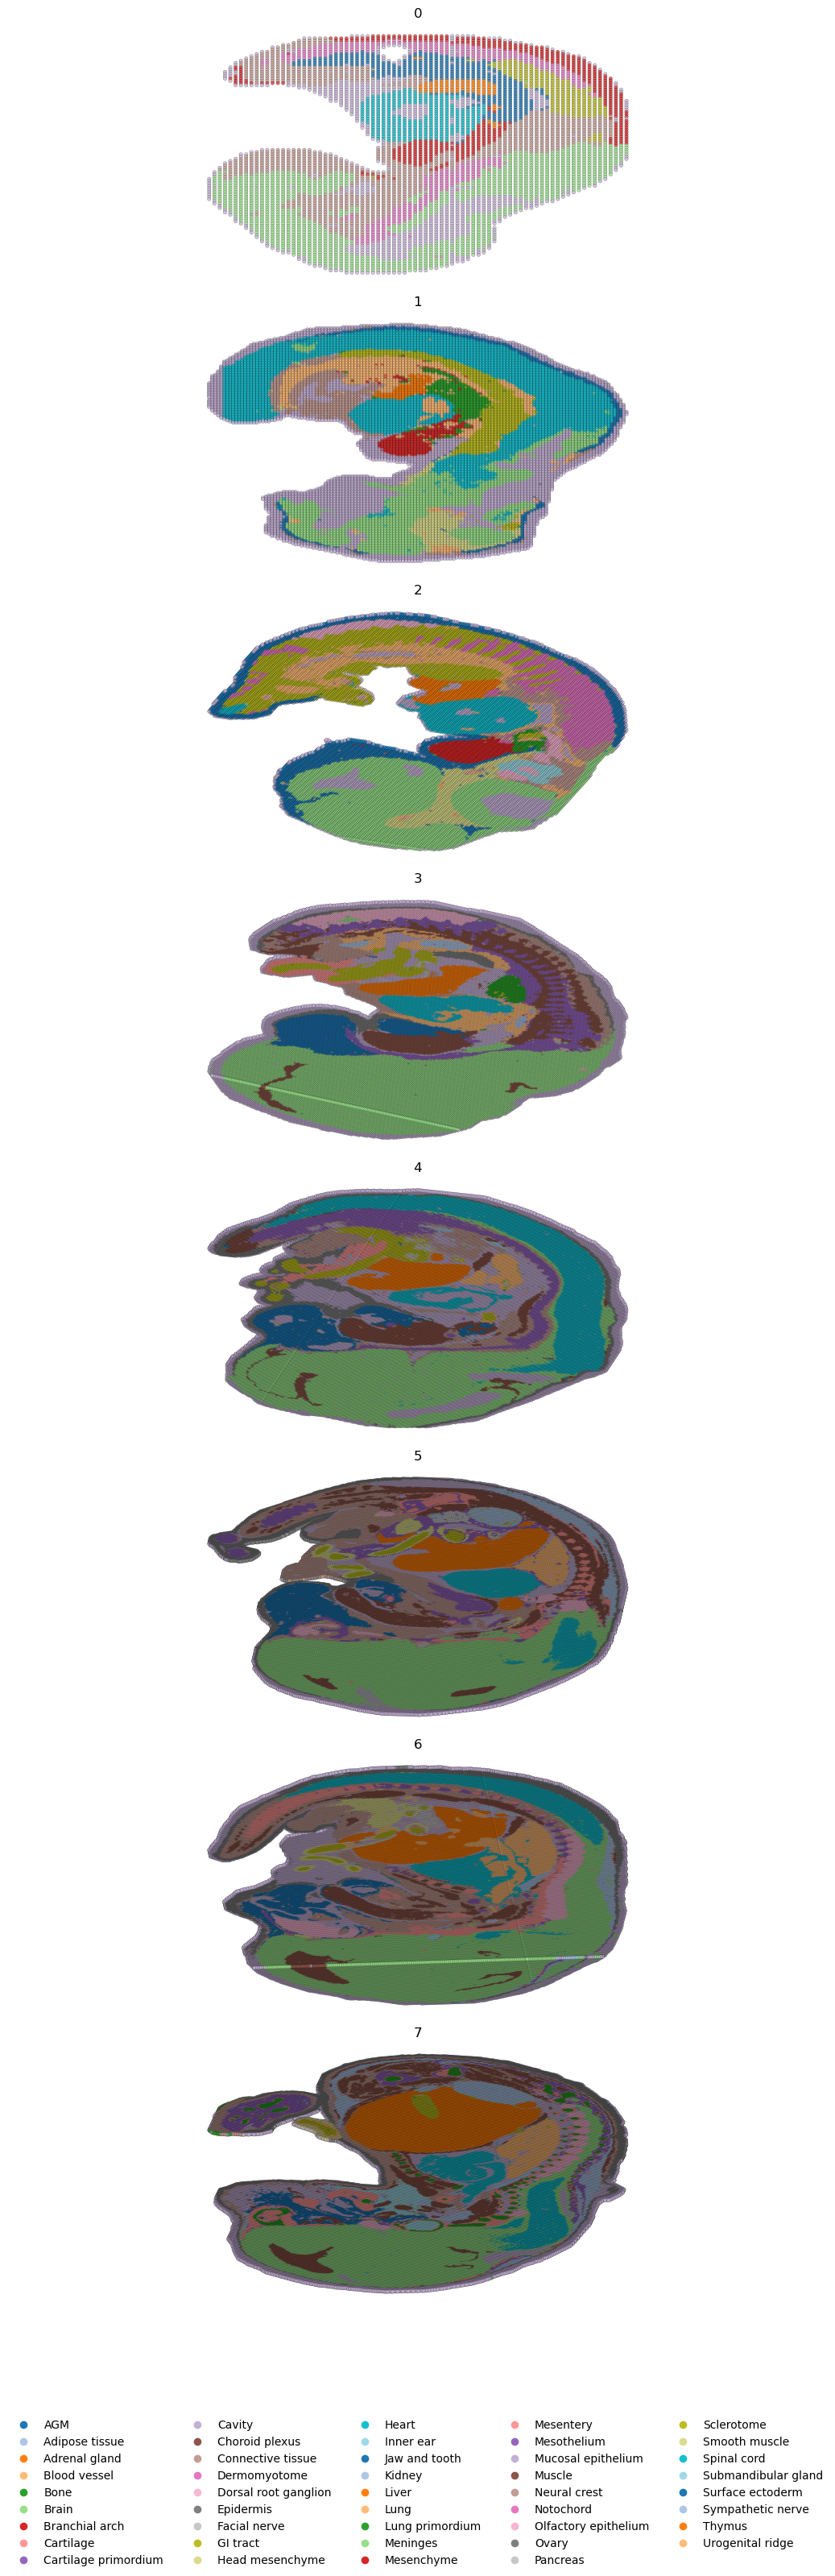

In [4]:
# Extract all unique cell types across all datasets
all_cell_types = set()
annotation_key= "celltype"
# annotation_key= "Annotation 3 (medium with DA)"
# annotation_key= "Annotation 2 (medium)"
# annotation_key= "Annotation 1 (broad)"
all_cell_types.update(scRNA.obs[annotation_key].unique())

# Create a consistent color map for all cell types
palette = sns.color_palette("tab20", len(all_cell_types))
color_dict = dict(zip(sorted(all_cell_types), palette))

time= scRNA.obs['day'].unique()


# Plot each dataset one by one
fig, axes = plt.subplots(len(time), 1, figsize=(6, 4 * len(time)))

if len(time) == 1:  # Ensure axes is iterable when only one dataset
    axes = [axes]


for ax, stage in zip(axes, time):
    # Assign colors based on the global dictionary
    adata= scRNA[scRNA.obs['day'] == stage]
    adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
    adata.obs["color"] = adata.obs[annotation_key].map(color_dict)

    # Plot spatial coordinates
    ax.scatter(
        adata.obsm["spatial"][:, 0], 
        adata.obsm["spatial"][:, 1], 
        c=adata.obs["color"], 
        s=10, alpha=0.7, edgecolors="k", linewidth=0.2
    )
    
    ax.set_title(stage, fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

# Create a single legend at the bottom
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[cell], markersize=8) 
           for cell in sorted(all_cell_types)]
labels = sorted(all_cell_types)

fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=10, frameon=False)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
plt.show()

# human
#### does not have temporal resolution; different static data from different patients

In [10]:
scRNA_human = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE312025_MShuman.h5ad'))


In [11]:
scRNA_human

AnnData object with n_obs × n_vars = 660801 × 266
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample_id', 'n_counts', 'batch', 'type', 'type_spec', 'leiden_0.1', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'project', 'rotate', 'flip', 'Level0', 'reclustered_Level0', 'x_rotated_2', 'y_rotated_2', 'sex', 'age', 'y_rotated_mod', 'x_rotated_mod', 'Level1', 'Level2', 'Level3', 'compartment', 'compartment_2', 'compartment_2_colors', 'region_area', 'Level1_5', 'library_id'
    uns: 'Level0_colors', 'Level0_wilcoxon', 'Level1_5_colors', 'Level1_5_wilcoxon', 'Level1_colors', 'Level1_wilcoxon', 'Level2_colors', 'Level2_wilcoxon', 'Level3_colors', 'Level3_wilcoxon', 'age_colors', 'compartment_2_colors', 'compartment_colors', 'dendrogram_Level1_5', 'leiden', 'leiden_0.1_colors', 'leiden_0.5_colors', 'leiden_1.5_colors', 'leiden_1_colors', '

In [ ]:
age= scRNA_human.obs['age']

# these are the sample ids we have; what's the difference?
sample_id= scRNA_human.obs['sample_id']

# ['CNTRL', 'EAE']; what is this exactly?
dtype= scRNA_human.obs['type']

# 
cell_id= scRNA_human.obs['cell_id']

# 
Level1= scRNA_human.obs['Level1']
Level2= scRNA_human.obs['Level2']
Level3= scRNA_human.obs['Level3']

In [36]:
age.unique()

array([53, 66, 57, 72, 47, 58])

In [37]:
sample_id.unique()

['MSa1', 'MSa2', 'CTRL2', 'CTRL1', 'MSi2', 'MSi1']
Categories (6, object): ['MSa1', 'MSa2', 'CTRL2', 'CTRL1', 'MSi2', 'MSi1']

In [38]:
dtype.unique()

['MS', 'CNTRL']
Categories (2, object): ['CNTRL', 'MS']

In [33]:
from collections import Counter

Counter(scRNA_human.obs['type'])

Counter({'MS': 465294, 'CNTRL': 195507})